## Parameters

In [55]:
import os

ROOT_DIR= os.path.abspath("../Mask_RCNN/")
MODEL_PATH = os.path.abspath("F:/downloads_trash/mask_rcnn_bubbles_0010.h5")
DATASET_DIR= os.path.abspath("../MangaBubbles/")

print("Root:", ROOT_DIR)
print("Model:", MODEL_PATH)
print("Dataset:", DATASET_DIR)

MIN_BLOB_SIZE= 8000
MIN_BLOB_OVERLAP= 1000

Root: C:\Programming\Bubbles\Mask_RCNN
Model: F:\downloads_trash\mask_rcnn_bubbles_0010.h5
Dataset: C:\Programming\Bubbles\MangaBubbles


## Imports

In [13]:
import sys
import cv2
import numpy as np
import skimage
import copy
import random
import glob
import scipy

sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils, visualize

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow


import matplotlib.pyplot as plt

## Helper Functions

In [78]:
def get_ax(rows=1, cols=1, size=10):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


def flatten(arrs):
	# Flatten blobs into single matrix for viewing
	x = np.zeros((arrs.shape[0], arrs.shape[1]), dtype=np.int32)
	for i in range(arrs.shape[2]):
		x[:,:]+= arrs[:,:,i]
	return x

def flattenList(lst):
	arr= np.array([x for x in lst])
	return flatten(arr)

# ==============================================================================

## Load Model and Image

In [61]:
class InferenceConfig(Config):
    BACKBONE= 'resnet50'
    
    IMAGE_RESIZE_MODE='crop'
    IMAGE_MIN_DIM=1728
    IMAGE_MAX_DIM=1728
    
    #TRAIN_ROIS_PER_IMAGE = 30
    
    #Blech
    NAME = "bubbles"
    NUM_CLASSES = 1 + 1  # background + 3 shapes
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    IMAGE_CHANNEL_COUNT= 1
    MEAN_PIXEL= np.array([123.7])

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir= ROOT_DIR)
model.load_weights(MODEL_PATH, by_name=True)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  1728
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1728
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [1728 1728    1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

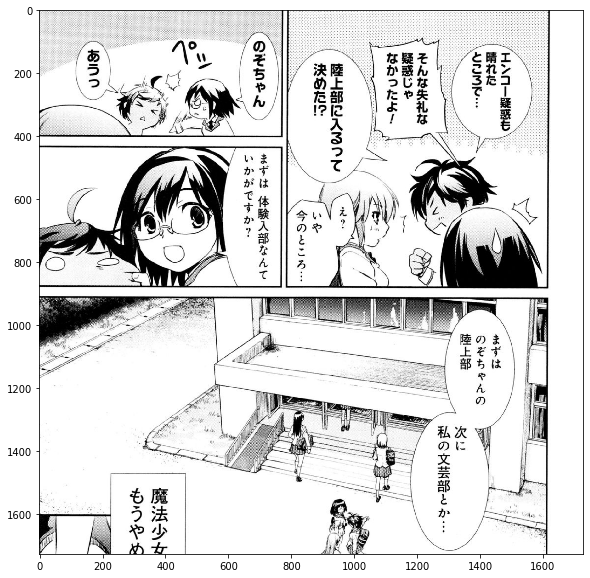

In [70]:
imPath= "C:/Programming/Bubbles/MangaBubbles/train_original/images/asuka/1/01_0018.jpg"
imPath= random.choice(glob.glob("C:/Programming/Bubbles/MangaBubbles/train_original/images/asuka/1/*"))

original_image= skimage.io.imread(imPath, as_gray=True)
if np.max(original_image) <= 1:
    original_image= original_image*255
if len(original_image.shape) == 2:
    original_image= original_image[..., np.newaxis]

original_image = utils.resize_image(original_image, min_dim=inference_config.IMAGE_MIN_DIM, max_dim=inference_config.IMAGE_MAX_DIM, min_scale=inference_config.IMAGE_MIN_SCALE, mode=inference_config.IMAGE_RESIZE_MODE)[0]
disp_image= np.concatenate((original_image, original_image, original_image),axis=2)


get_ax().imshow(disp_image.astype(np.uint8))

## Generate Masks

In [71]:
results = model.detect([original_image], verbose=1)

Processing 1 images
image                    shape: (1728, 1728, 1)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1728, 1728, 1)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1728.00000  int32
anchors                  shape: (1, 745767, 4)        min:   -0.20963  max:    1.17258  float32


## Filter Low Confidence Masks

[0.9996439  0.9987206  0.99795985 0.99795496 0.99787927 0.9976197
 0.99640745 0.9921972  0.98815465 0.97344524 0.92819285 0.83107954]


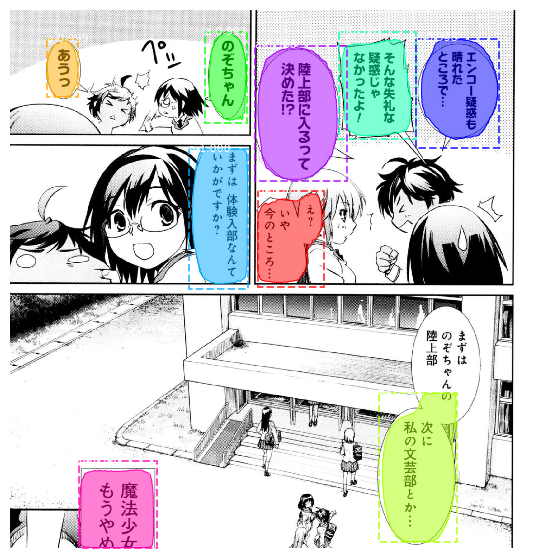

In [72]:
r = copy.deepcopy(results[0])
print(r['scores'])

inds= []
for i in reversed(range(len(r['scores']))):
    if r['scores'][i] > .98:
        break
    else:
        inds.append(i)

r['masks']= np.delete(r['masks'], inds, 2)
r['scores']= np.delete(r['scores'], inds, 0)
r['class_ids']= np.delete(r['class_ids'], inds, 0)
r['rois']= np.delete(r['rois'], inds, 0)

im= visualize.display_instances(disp_image, r['rois'], r['masks'], r['class_ids'], 
                            ['a']*123, r['scores'], ax=get_ax())

## Thesholding and Denoising

Selected blobs:
136: [1396  826]
137: [1286  398]
3418: [697 214]
3990: [400 241]
4315: [1174  266]
4422: [172 197]
4574: [1435  265]
4750: [921 345]
5162: [151 340]
5628: [832 555]
5629: [150 546]
5632: [679 660]
5650: [1021  566]
5947: [425 657]
5977: [885 735]
6178: [1414  666]
6216: [449 752]
6785: [142 829]
6786: [1018  826]
6915: [615 997]
6930: [1499 1242]
7062: [1346 1349]
7202: [ 524 1428]
7294: [1014 1054]
7634: [ 924 1200]
7740: [ 898 1118]
8294: [ 626 1266]
8337: [ 503 1342]
8535: [ 959 1329]
8969: [ 953 1462]
9072: [ 344 1596]
9090: [1525 1568]
9158: [ 109 1665]


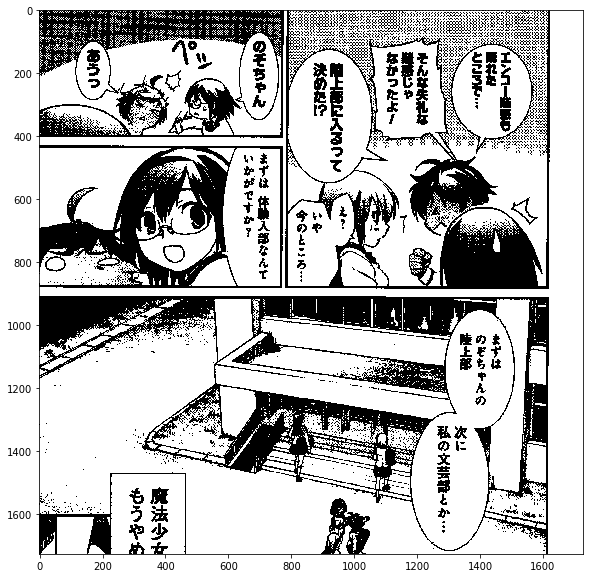

In [131]:
# Convert image to pure black and white
__, greyImage= cv2.threshold(original_image, 240, 1, cv2.THRESH_BINARY)
greyImage= greyImage*255

# Identify connected white blobs
blobStats= cv2.connectedComponentsWithStats(greyImage, 8, cv2.CV_16U)

# Identify larger blobs
blobLabels= [x for x in range(len(blobStats[2])) if blobStats[2][x][4] > MIN_BLOB_SIZE and x > 0]

# Move larger blobs to separate array
blobs= np.zeros(original_image.shape)
out= blobStats[1][...,np.newaxis] # Labeled (flat) image

for label in blobLabels[1:]:
    blobs= np.concatenate((blobs, out==label), axis=2)
blobs= blobs*255
    

debug_list= [str(x) + ": " + str(blobStats[3][x].astype(np.uint16)) for x in blobLabels]
print(f"Selected blobs:\n{chr(10).join(debug_list)}")
get_ax().imshow(greyImage.astype(np.uint8), cmap='Greys_r')

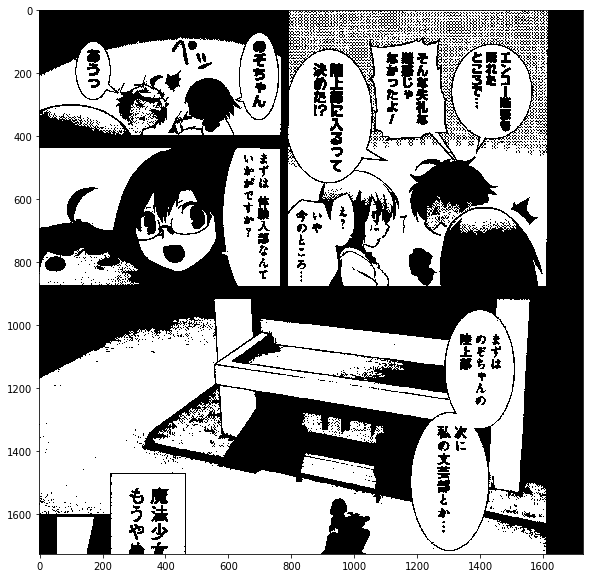

In [132]:
# Display blobs post-size-filter for debug
arr= flatten(blobs.astype(np.uint8))
disp_arr= np.dstack((arr, arr, arr))
get_ax().imshow(disp_arr, cmap='Greys_r')

## Identify Overlapping Components

Selected blobs:
5632: [679.43823118 660.04153515]
4422: [172.10534926 197.18681498]
4750: [921.61499908 345.86649215]
9072: [ 344.98040907 1596.43726384]
7062: [1346.16112553 1349.18282312]
5977: [885.30997827 735.63226877]
3418: [697.56635541 214.06850839]
4315: [1174.71424003  266.6569729 ]
4574: [1435.667937    265.17021097]


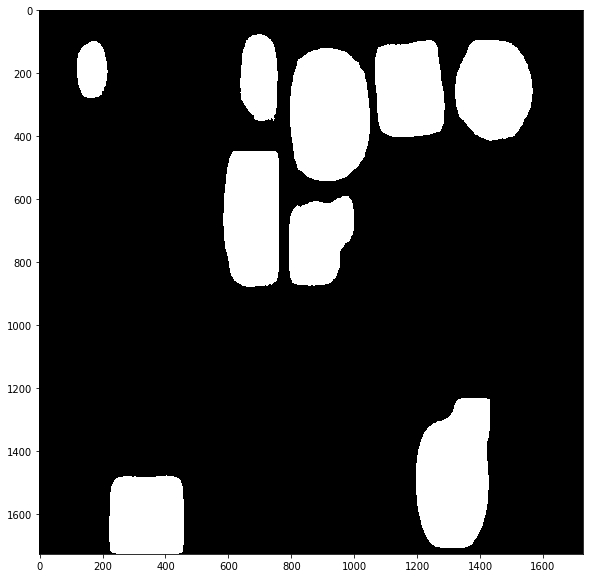

In [133]:
# Loop through the list of (large) blobs
filteredBlobLabels= set([])
for msk in range(r['masks'].shape[2]):
    mask= r['masks'][:,:,msk]
    
    # Select blobs whose centroid falls within the mask and whose overlap with that mask is sufficient
    for i in range(len(blobLabels)):
        center= blobStats[3][blobLabels[i]]
        center= center.astype(np.uint16)
        
        if mask[center[1]][center[0]] and np.count_nonzero(np.logical_and(mask, blobStats[1][:,:] == blobLabels[i])) > MIN_BLOB_OVERLAP:
            #print(f"Adding blob {blobLabels[i]} with center {center}")
            filteredBlobLabels.add(blobLabels[i])

flat_mask= flatten(r['masks'])
get_ax().imshow(flat_mask.astype(np.uint8), cmap='Greys_r')

debug_list= [str(x) + ": " + str(blobStats[3][x]) for x in filteredBlobLabels]
print(f"Selected blobs:\n{chr(10).join(debug_list)}")

Selected blobs:
5632: [679.43823118 660.04153515]
4422: [172.10534926 197.18681498]
4750: [921.61499908 345.86649215]
9072: [ 344.98040907 1596.43726384]
7062: [1346.16112553 1349.18282312]
5977: [885.30997827 735.63226877]
3418: [697.56635541 214.06850839]
4315: [1174.71424003  266.6569729 ]
4574: [1435.667937    265.17021097]


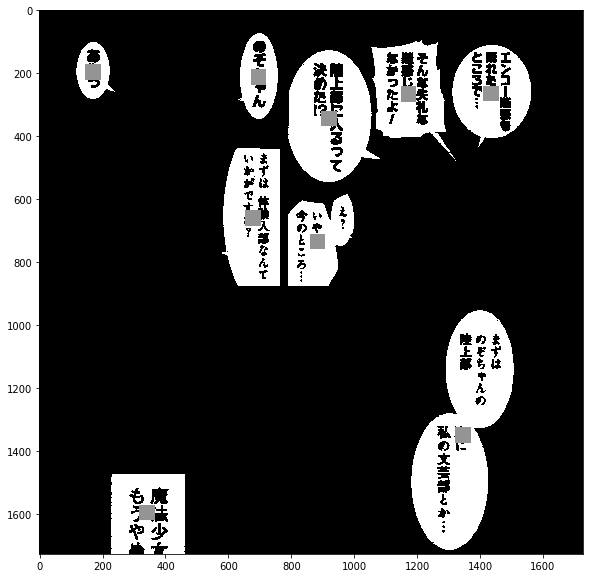

In [134]:
# Debug filtered blobs

dotSize= 25
grey= 126

test= np.zeros([original_image.shape[0], original_image.shape[1], len(filteredBlobLabels)])

for i,b in enumerate(filteredBlobLabels):
    test[:,:,i]= (blobStats[1][:,:] == b)*255
    
    center= blobStats[3][b].astype(np.uint16)
    centerBlock= [center[0]-dotSize, center[0]+dotSize, center[1]-dotSize, center[1]+dotSize]
    
    centerBlock[1]= np.minimum(centerBlock[1], test.shape[1])
    centerBlock[3]= np.minimum(centerBlock[3], test.shape[0])
    centerBlock[0]= np.maximum(centerBlock[0], 0)
    centerBlock[2]= np.maximum(centerBlock[2], 0)
    
    test[centerBlock[2]:centerBlock[3], centerBlock[0]:centerBlock[1], i] = grey
    
flat= (flatten(test.astype(np.uint8)))
flat= flat / np.max(flat) * 255
get_ax().imshow(flat, cmap='Greys_r')

debug_list= [str(x) + ": " + str(blobStats[3][x]) for x in filteredBlobLabels]
print(f"Selected blobs:\n{chr(10).join(debug_list)}")

## Final Result

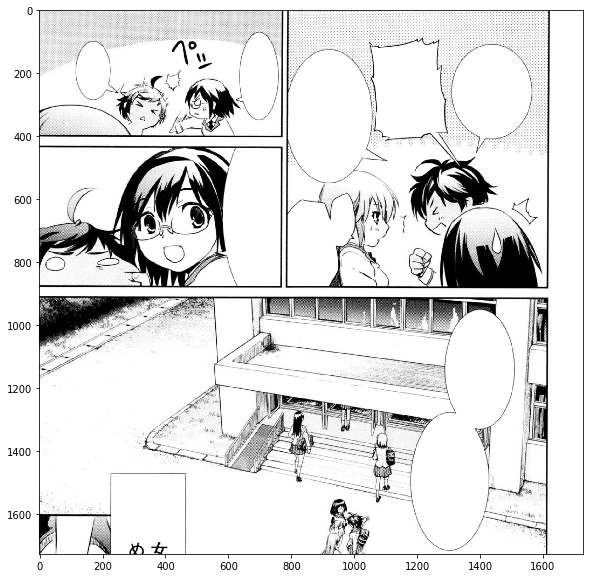

In [139]:
import png

cleaned_image= original_image
for b in filteredBlobLabels:
    comp= blobStats[1][:,:] == b
    comp= comp*255
    disp= np.dstack((comp,comp,comp))
    #get_ax().imshow(disp.astype(np.uint8), cmap='Greys_r')
    
    fill= scipy.ndimage.binary_fill_holes(comp).astype(np.uint8)*255
    
    cleaned_image= np.maximum(fill[:,:,np.newaxis], cleaned_image)
    
disp_image= np.concatenate((cleaned_image,cleaned_image,cleaned_image),axis=2)
get_ax().imshow(disp_image.astype(np.uint8), cmap='Greys_r')
    
png.from_array(np.uint8(cleaned_image), mode="L").save(f"C:/Users/Pray/Pictures/test3.png")